# VAE Drum Generator with timeshift and duration

In [1]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]

MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

In [2]:
import tensorflow as tf

# store tensorflow graph object here for multi threading
graph = tf.get_default_graph()

In [3]:
# CONSTANTS

resolution  = 4 # divide quater note into 4  = 16 notes

nb_bars = 2  # number of bars 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()        

In [5]:
from keras.layers import Layer

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs
   

Using TensorFlow backend.


In [6]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional, Lambda, Concatenate
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

batch_size = 16
n_z = 4
dropout_rate = 0.30

# encoder
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x1 = Reshape((1024,))(x)

timeshift_input = Input(shape=(len_seq, nb_notes), name='timeshift_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(timeshift_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x2 = Reshape((1024,))(x)

duration_input = Input(shape=(len_seq, nb_notes), name='duration_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(duration_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x3 = Reshape((1024,))(x)

x_merged =  Concatenate()([x1, x2, x3])
x = Dense(512, activation='relu')(x_merged)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# VAE 
mu = Dense(n_z, activation='linear')(x)
log_sigma = Dense(n_z, activation='linear')(x)

# KL Divergence
mu, log_sigma = KLDivergenceLayer()([mu, log_sigma])

# Sampling
def sample_z(args):
    
    mu, log_sigma = args
    
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    
    eps = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2.) * eps

z = Lambda(sample_z, output_shape=(n_z,), name='z')([mu, log_sigma])

encoder = Model([drum_input, timeshift_input, duration_input], [mu, log_sigma, z], name='encoder')
encoder.summary()

# decoder
latent_inputs = Input(shape=(n_z,), name='z_sampling')

# decoder for note
x = Dense(64, activation='relu')(latent_inputs)
x = Dropout(dropout_rate)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x1 = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x1)
x = Dense(1024, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(288, activation='sigmoid')(x) # output range shoud be 0. - 1.
note_out = Reshape((len_seq, nb_notes), name='note_output')(x)

# decoder for timeshift

x = Dense(1024, activation='relu')(x1)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(288, activation='tanh')(x) # output range shoud be -1. - 1.
time_out = Reshape((len_seq, nb_notes), name='time_output')(x)

x = Dense(1024, activation='relu')(x1)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(288, activation='sigmoid')(x) # output range shoud be -1. - 1.
duration_out = Reshape((len_seq, nb_notes), name='duration_output')(x)

decoder = Model(latent_inputs, [note_out, time_out, duration_out], name='decoder')
decoder.summary()

# VAE
inputs = [drum_input,timeshift_input, duration_input]
outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs, name='VAE')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
timeshift_input (InputLayer)    (None, 32, 9)        0                                            
__________________________________________________________________________________________________
duration_input (InputLayer)     (None, 32, 9)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32, 128)      37888       drum_input[0][0]                 
__________________________________________________________________________________________________
bidirectio

In [7]:
vae.load_weights("./models/vae_model_timeshift_duration.h5")
encoder.load_weights("./models/encoder_model_timeshift_duration.h5")
decoder.load_weights("./models/decoder_model_timeshift_duration.h5")

[[-0.61278456 -1.4755326  -0.32247135  1.81642545]]
notes


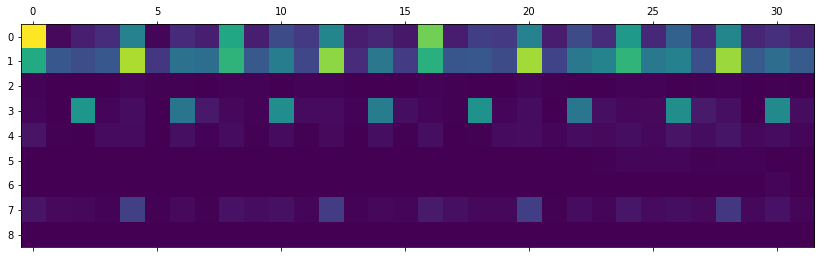

timeshift


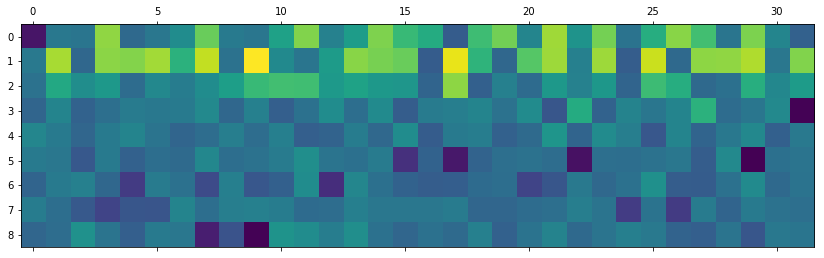

duration


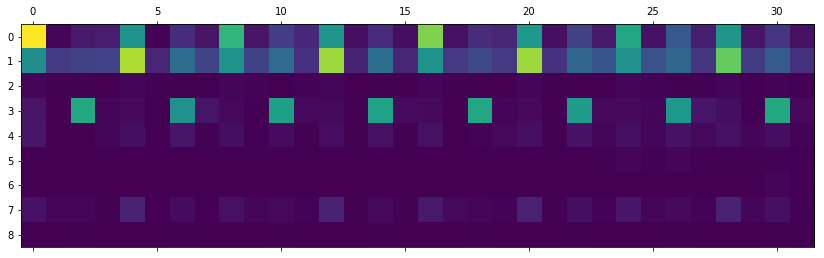



[[ 0.32793579 -1.61928358  0.10292913 -1.97239435]]
notes


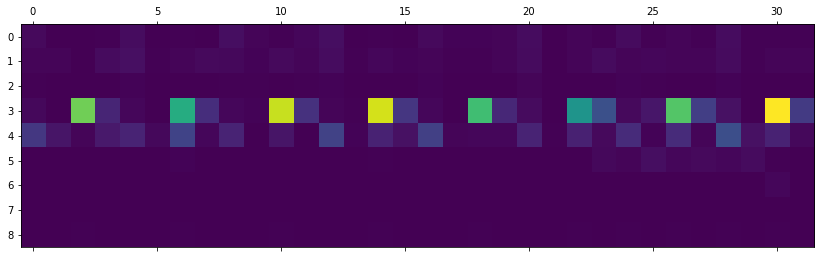

timeshift


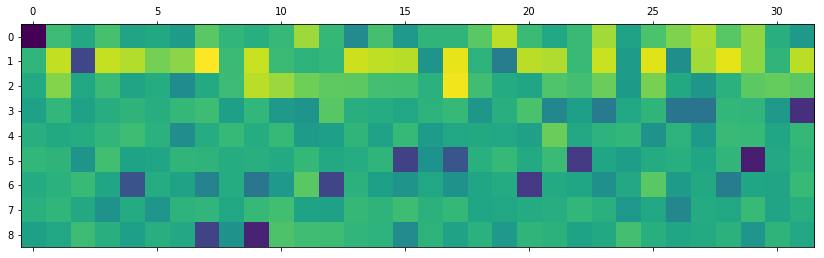

duration


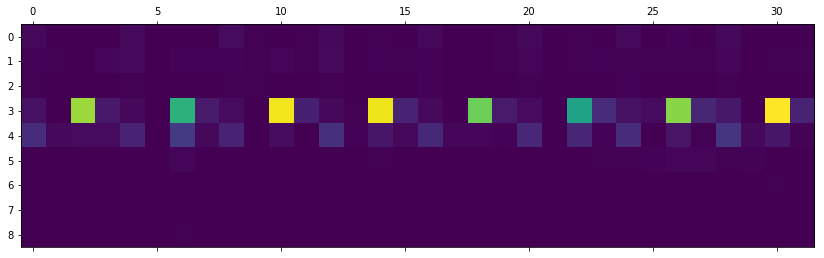



[[ 0.25082099 -0.52144027 -0.4462021  -0.3672427 ]]
notes


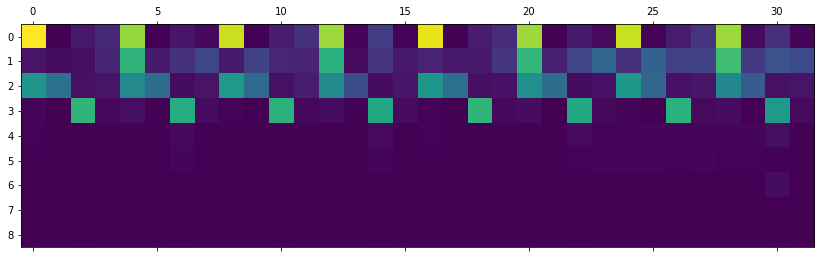

timeshift


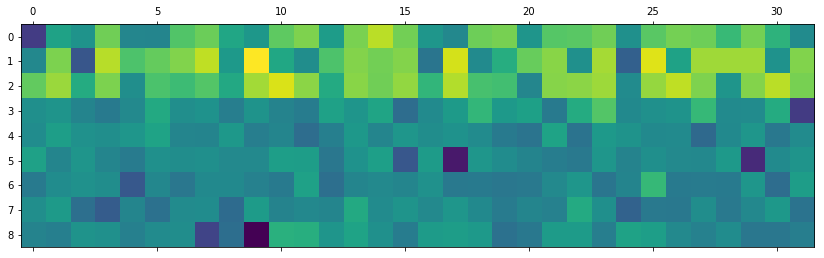

duration


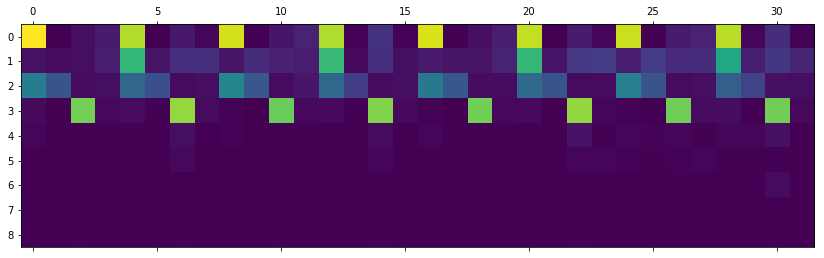



[[-0.46951605  0.54992351  0.37783267 -0.41856873]]
notes


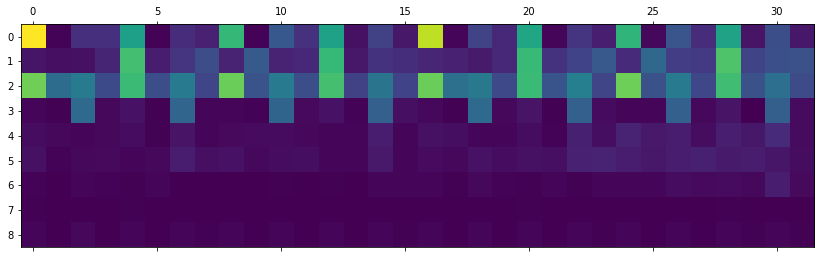

timeshift


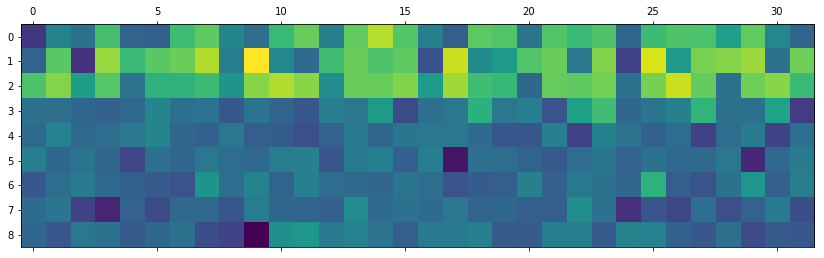

duration


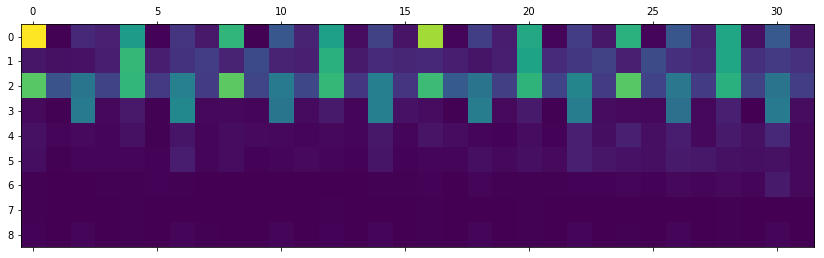

In [8]:
for i in range(4):
    random_z = np.random.normal(0.0, 1.0, (1, n_z))
    print (random_z)
    a, t, d = decoder.predict(random_z)    
    print('notes')
    plot_drum_matrix(a)
    print('timeshift')
    plot_drum_matrix(t)
    print('duration')
    plot_drum_matrix(d)
    print 
    print

velocity


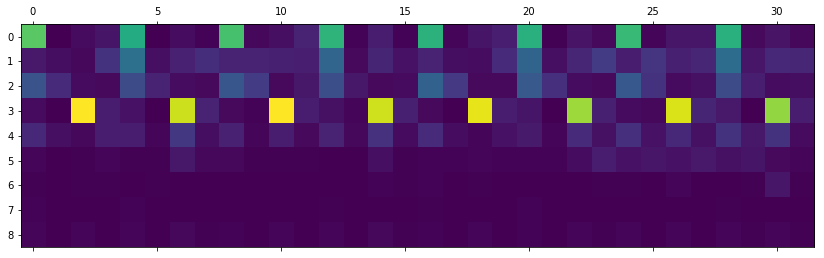

micro timing


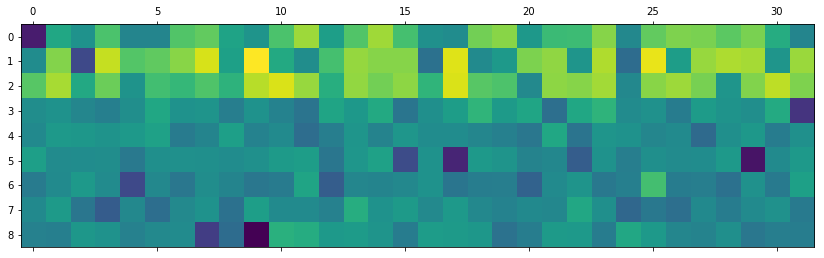

duration


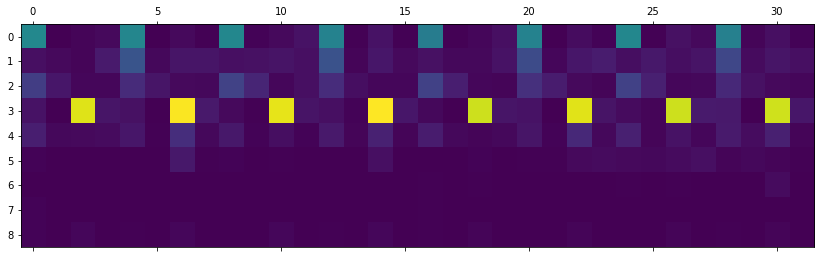

nb_onsets 50
velocity - after sampling


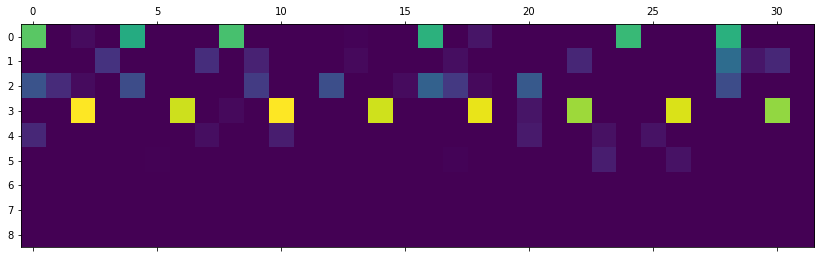

In [ ]:
import random
import OSC
import threading
from IPython.display import clear_output
from time import sleep

stop_interpolation = False
z_prev = None

try:
    if oscclient is not None:
        oscclient.close()
        oscclient = None
        
    if oscserver is not None:
        oscserver.close()
        oscserver = None
except:
    None

def stochastic_sampling(sequence, nb_onsets, temperature = 1.0):
    org_shape = sequence.shape
    
    # temperature    
    a = np.power(sequence, 1.0/temperature)

    # sampling
    p = a.flatten()
    if np.sum(p) > 0.0:
        p = p * 1.0/float(np.sum(p)) # normalize
    
    if np.count_nonzero(p) < nb_onsets: # if probabilities are too low
        nb_onsets = np.count_nonzero(p) 

    # get indices    
    sampled = np.random.choice( len(p), nb_onsets, replace=False, p=p)
    nb_onsets = np.count_nonzero(p)
    
    # output sequence
    output = np.zeros_like(p)
    output[sampled] = sequence.flatten()[sampled] 
    return output.reshape(org_shape)


    
def generate_random_sequence(random_z = None, verbose=True):
    global graph
    if random_z is None:
        random_z = np.random.normal(0.0, 1.0, (1, n_z))
    with graph.as_default():
        a, t, d = decoder.predict(random_z)
    if verbose:
        clear_output()
        print("velocity")
        plot_drum_matrix(a)
        print("micro timing")
        plot_drum_matrix(t)
        print("duration")
        plot_drum_matrix(d)
    return np.squeeze(a), np.squeeze(t), np.squeeze(d)
    
# send matrix as a string, then parse in max
def send_generated_notes(sequence_matrix, timeshift_matrix, duration_matrix, threshold):       
    notes_array = sequence_matrix.transpose()
    timeshift_array = timeshift_matrix.transpose()
    duration_matrix = duration_matrix.transpose()
    
    try:
        for index, row in enumerate(notes_array):
            msg = OSC.OSCMessage("/generated_notes_seq")
            msg.append(index + 1)
            for f in row:
                if f > threshold:
                    i = int(f * 127)
                else:
                    i = 0
                msg.append(i)                
            oscclient.send(msg)
            
        for index, row in enumerate(timeshift_array):
            msg = OSC.OSCMessage("/generated_timeshift_seq")
            msg.append(index + 1)
            for f in row: # convert (-1, 1) to (0, 127) 
                i =  int(min(max(0., f * 64. + 64.), 127.))  
                msg.append(i)                
            oscclient.send(msg)
            
        for index, row in enumerate(duration_matrix):
            msg = OSC.OSCMessage("/generated_duration_seq")
            msg.append(index + 1)
            for f in row: # 0 - 1
                msg.append(f)                
            oscclient.send(msg)
            
        msg = OSC.OSCMessage("/generation_done")
        oscclient.send(msg)
    except Exception as exp:
        print "error", exp
        
def sample_seq_callback(path, tags, args, source):
    global z_prev
    try:
        if len(args) < 4:
            threshold = args[0]
        else:
            threshold = 0.0
            nb_onsets = args[3]
           
        use_prev = args[1]
        
        temperature = args[2]
        
        if use_prev:
            random_z = z_prev
        else:
            random_z = np.random.normal(0.0, 1.0, (1, n_z))
        z_prev = random_z     
        sequence, timeshift, durations = generate_random_sequence(z_prev)
        
        # if nb_onsets are not set, set it using generated sequence and threshold
        if len(args) < 4:
            nb_onsets = np.count_nonzero(sequence > threshold)
        print "nb_onsets", nb_onsets
        
        sequence_sampled = stochastic_sampling(sequence, nb_onsets, temperature)
        print("velocity - after sampling")
        plot_drum_matrix(sequence_sampled)
        send_generated_notes(sequence_sampled, timeshift, durations, threshold)
    except Exception as exp:
        print "error", exp        
    
def generate_seq_callback(path, tags, args, source):
    global z_prev
    try:
        use_prev = False
        if len(args) > 1:
            use_prev = args[1]
        if len(args) > 0:
            threshold = args[0]
        else:
            threshold = 0.0
        
        if use_prev:
            random_z = z_prev
        else:
            random_z = np.random.normal(0.0, 1.0, (1, n_z))
        z_prev = random_z
        sequence, timeshift, durations = generate_random_sequence(random_z)
        send_generated_notes(sequence, timeshift, durations, threshold)
    except Exception as exp:
        print "error", exp    
        
def variation_seq_callback(path, tags, args, source):
    try:
        if len(args) == 2:
            threshold = args[0]
            variation_range = args[1]
        else:
            threshold = 0.0
            variation_range = 0.1
        
        random_z = z_prev + np.random.normal(variation_range*-1., variation_range, (1, n_z))
        sequence, timeshift, durations = generate_random_sequence(random_z)
        
        send_generated_notes(sequence, timeshift, durations, threshold)
    except Exception as exp:
        print "error", exp    

def stop_interpolation_callback(path, tags, args, source):
    global stop_interpolation
    stop_interpolation = True
    print stop_interpolation

def interpolate_seq_callback(path, tags, args, source):
    global stop_interpolation    
    try:
        if len(args) == 3:
            threshold = args[0]
            interpolation = args[1]
            sleep_duration  = args[2]
        else:
            threshold = 0.0
            interpolation = 8
            sleep_duration = 4
            
        z_a = np.random.normal(0.0, 1.0, (1, n_z)) # seed 1
        z_b = np.random.normal(0.0, 1.0, (1, n_z)) # seed 2
    
        for i in range(interpolation + 1):
            if stop_interpolation:
                stop_interpolation = False
                break
            z = z_a * (interpolation - i)/float(interpolation) + z_b * i/float(interpolation)
            sequence, timeshift, durations = generate_random_sequence(z)
            send_generated_notes(sequence, timeshift, durations, threshold)
            
            # progress bar
            msg = OSC.OSCMessage("/interpolation_id")
            msg.append(i)
            msg.append(interpolation)            
            oscclient.send(msg)
            
            # sleep
            sleep(sleep_duration)
        msg = OSC.OSCMessage("/interpolation_done")
        oscclient.send(msg)
    except Exception as exp:
        print "error", exp    

        
# OSC server / clients
oscclient = OSC.OSCClient()
oscclient.connect( ("localhost", 8013) )
   
oscserver = OSC.OSCServer(("localhost", 8020))
oscserver.timeout = 0

oscserver.addMsgHandler( "/generate_seq", generate_seq_callback )
oscserver.addMsgHandler( "/sample_seq", sample_seq_callback )
oscserver.addMsgHandler( "/variation_seq", variation_seq_callback )
oscserver.addMsgHandler( "/interpolate_seq", interpolate_seq_callback )
oscserver.addMsgHandler( "/stop_interpolation", stop_interpolation_callback )
st = threading.Thread( target = oscserver.serve_forever )
st.start()
print("ready")